# ЛР 3. Исследование данных: сезонность, сводные статистики, resample

Баранов Владимир, ШАД-311

## Формулировка заданий

### 1. Годовая сезонность
- Построить график `passengers.csv`.
- Кратко описать сезонные пики и спады по годам.

### 2. Анализ по месяцам
- Сравнить **январь** и **июль** в разные годы.
- Построить графики и дать краткое описание различий.

### 3. Среднее и дисперсия по годам
- Рассчитать для каждого года среднее и дисперсию.
- Построить таблицу или график.

### 4. Разности между месяцами
- (a) Абсолютные: \(x_t - x_{t-1}\)  
- (b) Относительные (%): \(\frac{x_t - x_{t-1}}{x_{t-1}} \times 100\)  
- Построить графики и описать результат.

### 5. Resample (изменение частоты)
- (a) Понизить частоту до **года** или **квартала** (`resample('Y')`, `'Q'`), выбрать `sum` или `mean`.
- (b) Повысить до **недели** или **дня** (`resample('W')`, `'D'`), оценить целесообразность.

### 6. Анализ неполных данных (`passengers2.csv`)
- Восполнить пропуски (например, интерполяцией или сглаживанием).  
- Повторить шаги 1–5.  
- Сравнить результаты с полным датасетом и сделать краткий вывод.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 120)
np.random.seed(42)
pd.set_option("display.max_columns", 100)

In [2]:
# --- Функции для восстановления и анализа временного ряда ---

def impute_series(s, method: str = 'time'):
    """
    Восполняет пропуски в серии s выбранным методом:
    - 'time' — линейная интерполяция по времени;
    - 'ma'   — скользящее среднее (окно=3, центрированное);
    - 'ewm'  — экспоненциальное сглаживание (alpha=0.3).
    """
    if method == 'time':
        return s.interpolate(method='time').bfill().ffill()

    if method == 'ma':
        ma = s.rolling(window=3, center=True, min_periods=1).mean()
        out = s.copy()
        out[s.isna()] = ma[s.isna()]
        return out.bfill().ffill()

    if method == 'ewm':
        filled = s.ffill()
        smoothed = filled.ewm(alpha=0.3, adjust=False).mean()
        out = s.copy()
        out[out.isna()] = smoothed[out.isna()]
        return out.bfill().ffill()

    # По умолчанию — линейная интерполяция
    return s.interpolate().bfill().ffill()


def monthly_profile(s):
    """
    Возвращает средние значения по месяцам (1–12)
    для оценки сезонного профиля ряда.
    """
    return s.groupby(s.index.month).mean().reindex(range(1, 13))

### Загрузка данных


In [4]:
from pathlib import Path


def load_dataset(filename):
    p = Path(filename)
    df = pd.read_csv(p)
    date_col = next((c for c in df.columns if str(c).lower() in {'month','date','ds'}), df.columns[0])
    val_col  = next((c for c in df.columns if str(c).lower() in {'passengers','value','y'}), df.columns[1])
    df = df[[date_col, val_col]].rename(columns={date_col:'date', val_col:'value'})
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').set_index('date')
    if df.index.freq is None and len(df)>2:
        diffs = df.index.to_series().diff().dropna()
        if (diffs.dt.days.between(28,31).mean() > 0.8):
            df = df.asfreq('MS')
    s = pd.to_numeric(df['value'], errors='coerce')
    return s


full = load_dataset("/content/passengers.csv")
part = load_dataset("/content/passengers2.csv")
part_imp = impute_series(part, method="time") # здесь предусмотрены заполнения также с method='ma' (moving_average, скользящее среднее) и ewm (exponential weighted moving average, экспоненциальное сглаживание)
full.head(), part.head(), part_imp.head()


(date
 1949-01-01    112
 1949-02-01    118
 1949-03-01    132
 1949-04-01    129
 1949-05-01    121
 Freq: MS, Name: value, dtype: int64,
 date
 1949-01-01    112
 1949-02-01    118
 1949-03-01    132
 1949-04-01    129
 1949-05-01    121
 Freq: MS, Name: value, dtype: int64,
 date
 1949-01-01    112
 1949-02-01    118
 1949-03-01    132
 1949-04-01    129
 1949-05-01    121
 Freq: MS, Name: value, dtype: int64)

## Задание 1 — Годовая сезонность


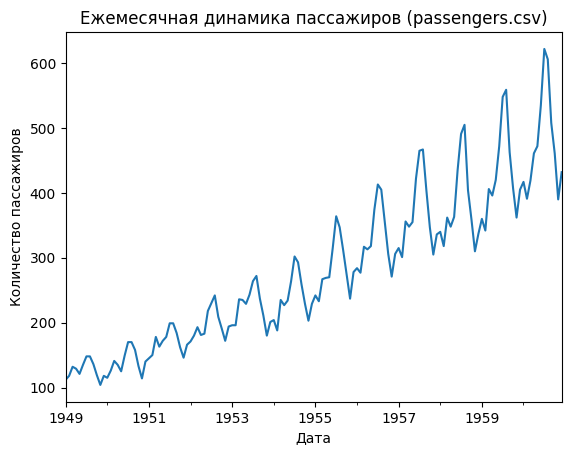

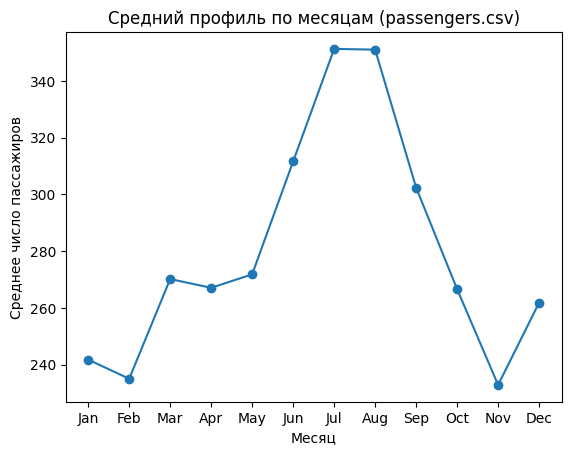

Описание сезонности: Максимум — Июль, минимум — Ноябрь. Амплитуда ≈ 118.5 (42.3% от среднего).


In [5]:

def seasonality_summary(s):
    m = monthly_profile(s)
    peak = int(m.idxmax())
    trough = int(m.idxmin())
    amp = float(m.max() - m.min())
    rel = float((m.max() - m.min()) / m.mean() * 100) if m.mean() != 0 else float('nan')

    months = ['Январь','Февраль','Март','Апрель','Май','Июнь',
              'Июль','Август','Сентябрь','Октябрь','Ноябрь','Декабрь']

    return (
        f"Максимум — {months[peak - 1]}, минимум — {months[trough - 1]}. "
        f"Амплитуда ≈ {amp:.1f} ({rel:.1f}% от среднего)."
    )

ax = full.plot(title="Ежемесячная динамика пассажиров (passengers.csv)")
ax.set_xlabel("Дата")
ax.set_ylabel("Количество пассажиров")
plt.show()

mp_full = monthly_profile(full)
ax = mp_full.plot(marker="o", title="Средний профиль по месяцам (passengers.csv)")
ax.set_xlabel("Месяц")
ax.set_ylabel("Среднее число пассажиров")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()

print("Описание сезонности:", seasonality_summary(full))

Выводы:

- Чёткий восходящий тренд по годам (рост базового уровня пассажиропотока).

- Сильная годовая сезонность: волны повторяются каждый год.

- Пик летом (обычно июль/август), минимум зимой (декабрь–январь).

- Амплитуда сезонности заметная: летние месяцы существенно выше зимних.

- Сезонный профиль устойчивый (повторяемый год к году).

## Задание 2 — Анализ января и июля
Рассмотрим значения за **январь** и **июль** по разным годам, чтобы убрать влияние общей годовой сезонности.


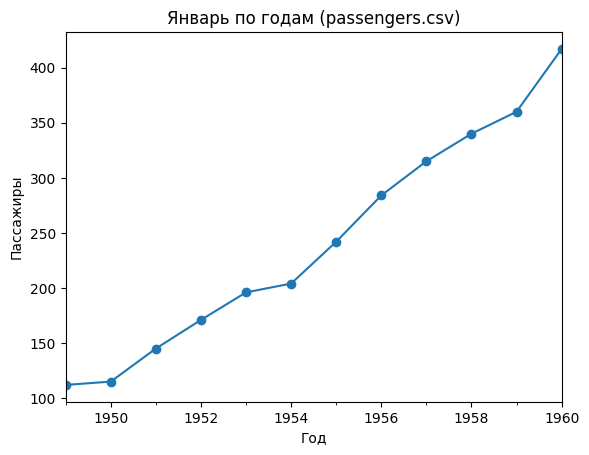

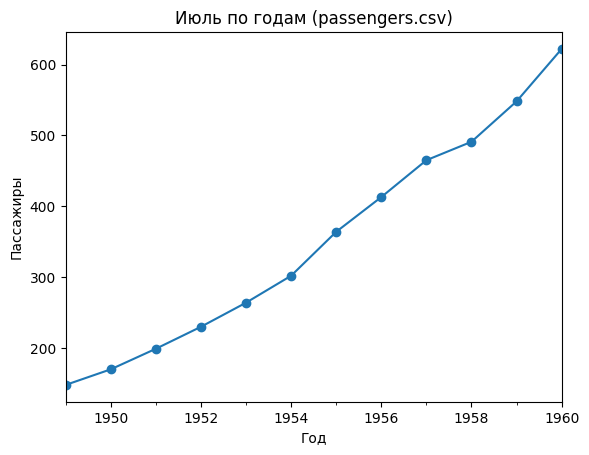

Январь: мин=112, макс=417, среднее=241.8
Июль:   мин=148, макс=622, среднее=351.3


In [6]:
jan = full[full.index.month==1]
jul = full[full.index.month==7]

ax = jan.plot(marker="o", title="Январь по годам (passengers.csv)")
ax.set_xlabel("Год"); ax.set_ylabel("Пассажиры")
plt.show()

ax = jul.plot(marker="o", title="Июль по годам (passengers.csv)")
ax.set_xlabel("Год"); ax.set_ylabel("Пассажиры")
plt.show()

print(f"Январь: мин={jan.min():.0f}, макс={jan.max():.0f}, среднее={jan.mean():.1f}")
print(f"Июль:   мин={jul.min():.0f}, макс={jul.max():.0f}, среднее={jul.mean():.1f}")


Выводы:

- Январские значения растут из года в год, но остаются среди самых низких по сезону.

- Дисперсия в январе умеренная: колебания между годами не велики.

- Июль уверенно растёт год от года и находится на сезонном пике.

- Вариативность июля выше январской (летний спрос чувствительнее к тренду).

## Задание 3 — Среднее и дисперсия по годам


In [7]:
yearly = full.groupby(full.index.year).agg(['mean','var'])
yearly.index.name = "year"
yearly


,mean,var
year,,
1949,126.666667,188.242424
1950,139.666667,363.696970
1951,170.166667,339.969697
1952,197.000000,527.454545
1953,225.000000,810.363636
1954,238.916667,1219.719697
1955,284.000000,1775.818182
1956,328.250000,2290.750000
1957,368.416667,3351.356061


## Задание 4 — Разности
а) Абсолютные разности между соседними месяцами.  
б) Относительные разности (проценты прироста).


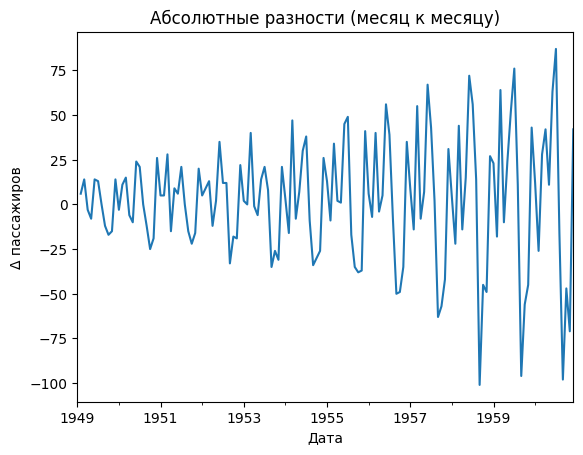

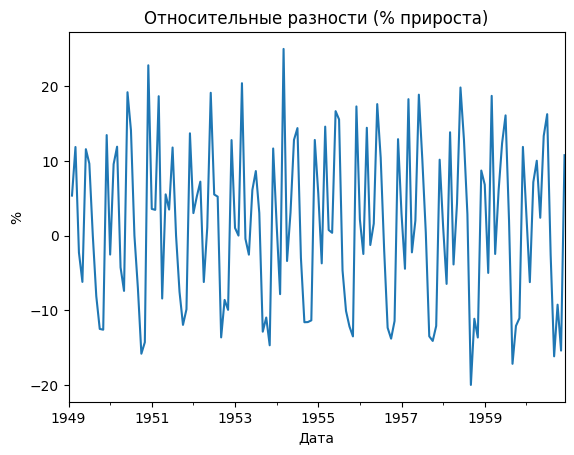

In [8]:
abs_diff = full.diff()
rel_diff = full.pct_change()*100

ax = abs_diff.plot(title="Абсолютные разности (месяц к месяцу)")
ax.set_xlabel("Дата"); ax.set_ylabel("Δ пассажиров")
plt.show()

ax = rel_diff.plot(title="Относительные разности (% прироста)")
ax.set_xlabel("Дата"); ax.set_ylabel("%")
plt.show()


Выводы:

- Периодичность разностей: весной—началом лета преобладают плюсы (рост к пику), осенью—зимой минусы (спад).

- Крупные положительные скачки соответствуют входу в высокий сезон.

- Относительный рост в процентах более заметен в ранние годы (низкая база).

- Сезонные колебания в % отражают те же фазы, но их амплитуда со временем относительно сглаживается.

## Задание 5 — Изменение частоты (resample)
а) Понижение до **года**/**квартала** — логично использовать *sum* для суммарных месячных объёмов (или *mean* для средних уровней).  
б) Повышение до **недели/дня** — интерполяция (новой информации не добавляет, но полезна для визуализации/стыковки).


/tmp/ipython-input-1855775479.py:2: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_sum = full.resample("A").sum()


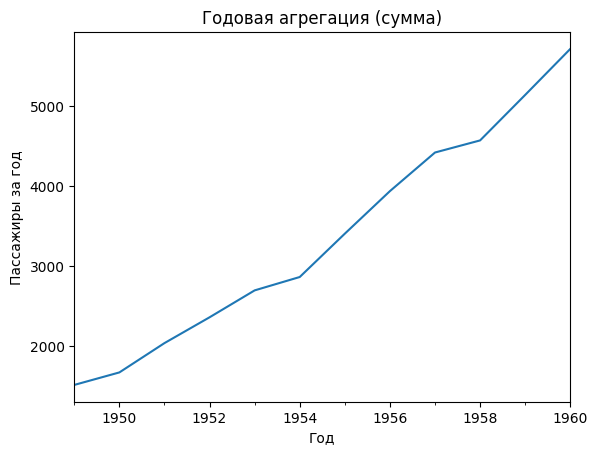

/tmp/ipython-input-1855775479.py:9: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarter_sum = full.resample("Q").sum()


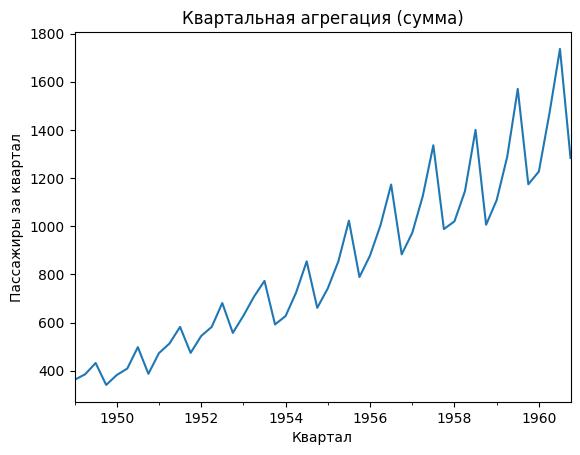

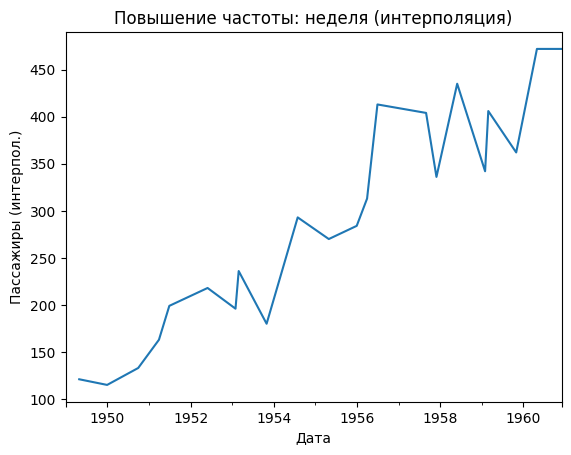

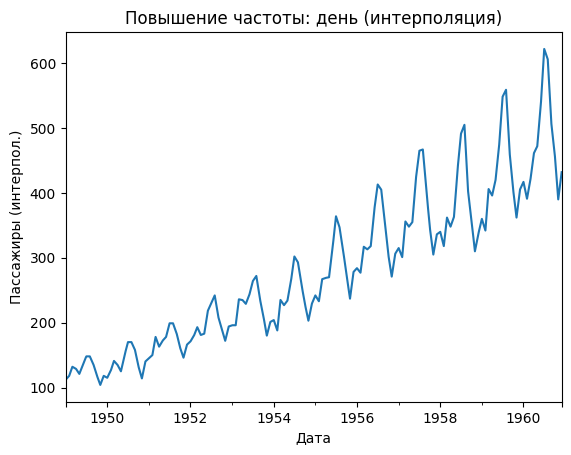

In [9]:
# Годовая агрегация (сумма за год)
annual_sum = full.resample("A").sum()
ax = annual_sum.plot(title="Годовая агрегация (сумма)")
ax.set_xlabel("Год")
ax.set_ylabel("Пассажиры за год")
plt.show()

# Квартальная агрегация (сумма за квартал)
quarter_sum = full.resample("Q").sum()
ax = quarter_sum.plot(title="Квартальная агрегация (сумма)")
ax.set_xlabel("Квартал")
ax.set_ylabel("Пассажиры за квартал")
plt.show()

# --- Повышение частоты (интерполяция) ---
weekly = full.resample("W").interpolate(method="time")
daily  = full.resample("D").interpolate(method="time")

# Еженедельные значения
ax = weekly.plot(title="Повышение частоты: неделя (интерполяция)")
ax.set_xlabel("Дата")
ax.set_ylabel("Пассажиры (интерпол.)")
plt.show()

# Ежедневные значения
ax = daily.plot(title="Повышение частоты: день (интерполяция)")
ax.set_xlabel("Дата")
ax.set_ylabel("Пассажиры (интерпол.)")
plt.show()

Выводы:

- Чёткий и плавный рост годовых сумм — удобный вид для отчётности и долгосрочных сравнений.

- Для месячных объёмов логична агрегирующая функция sum (суммарный пассажиропоток за год).

- Видна внутригодовая волна (пики во 2–3 кварталах).

- Для кварталов тоже корректно sum (накопление объёмов).

- Повышение частоты через интерполяцию сглаживает кривую и не добавляет новой информации.

- Полезно для стыковки с данными другой частоты/визуализации, но не для выводов об истинной внутри-месячной динамике.

## Задание 6 — Анализ неполного датасета и сравнение
Восполним пропуски в **passengers2.csv** методом линейной интерполяции по времени (можно заменить на `ma`/`ewm`) и повторим пункты 1–5.  
Затем сравним сезонные профили и годовые суммы.


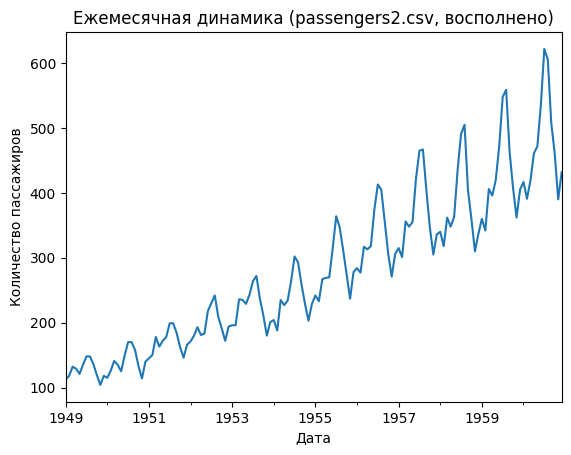

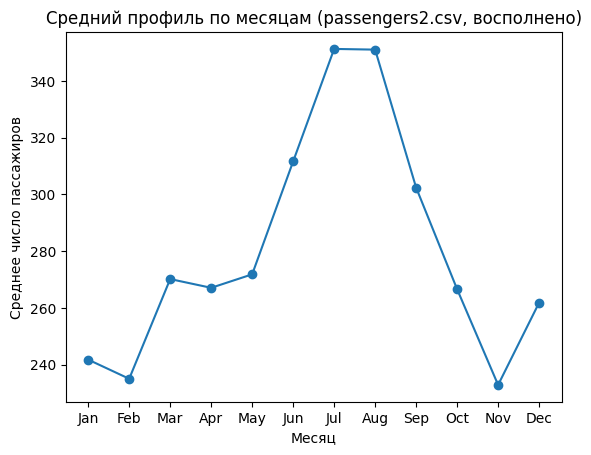

Описание сезонности (восполненные данные): Максимум — Июль, минимум — Ноябрь. Амплитуда ≈ 118.5 (42.3% от среднего).


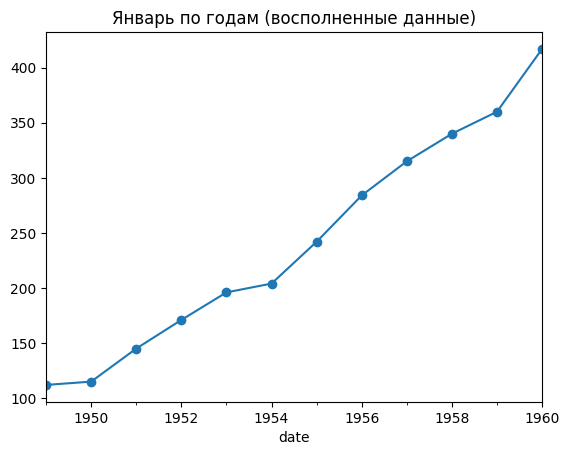

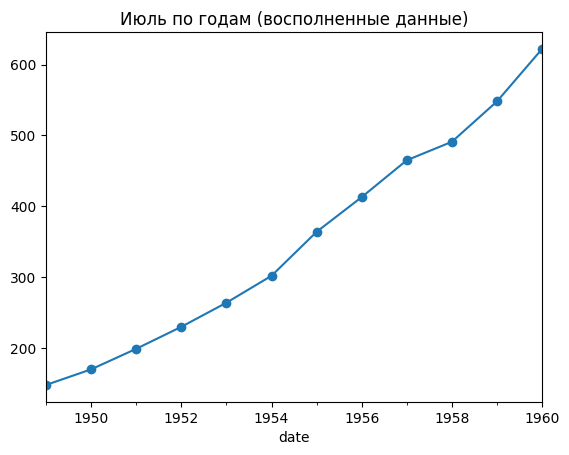

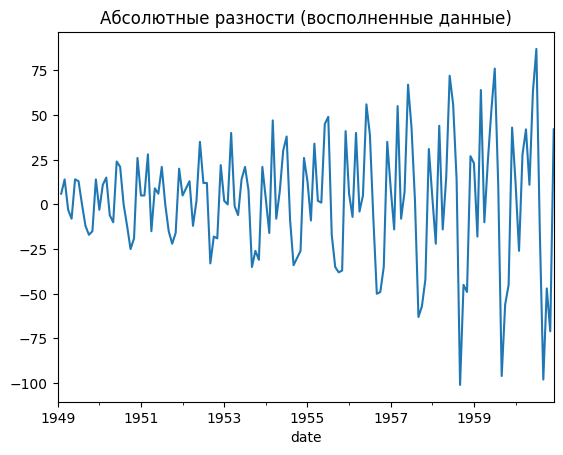

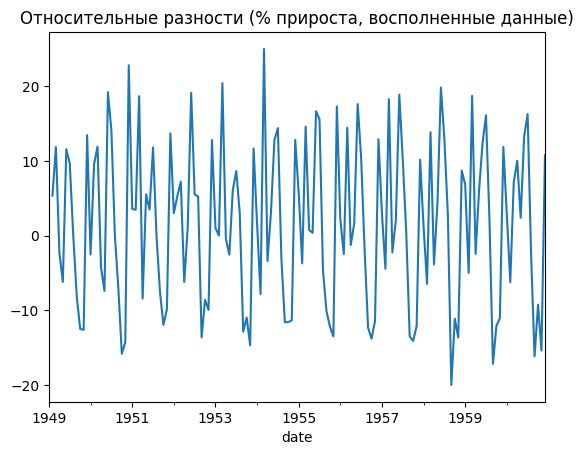

/tmp/ipython-input-4159097608.py:38: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_i = part_imp.resample("A").sum()
/tmp/ipython-input-4159097608.py:39: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  q_i = part_imp.resample("Q").sum()


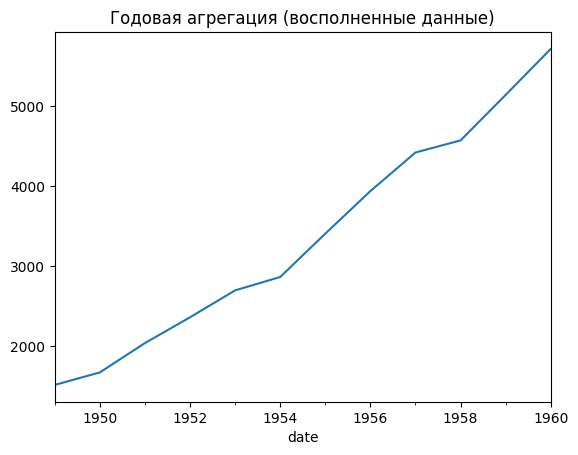

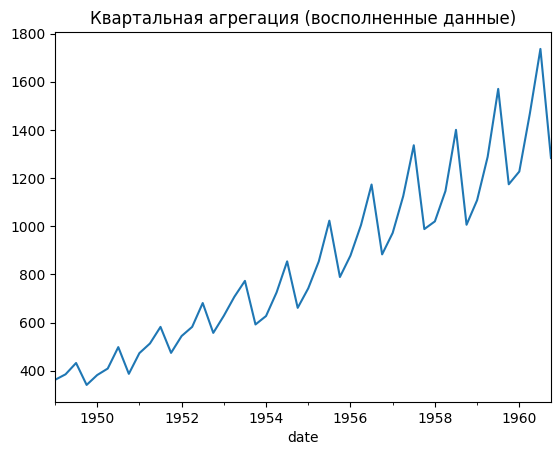

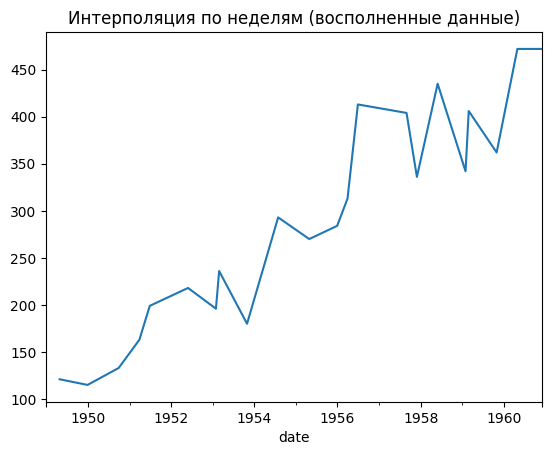

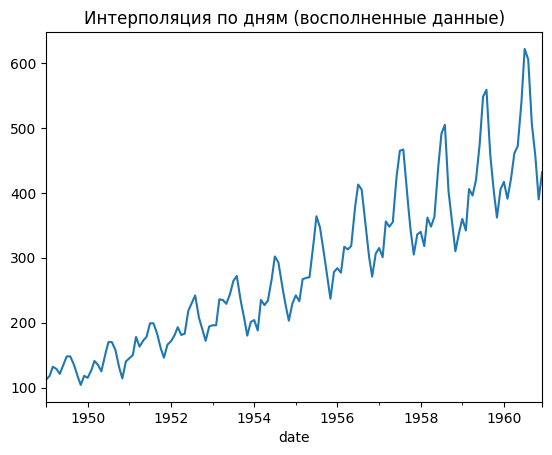

Сравнение месячных профилей: MAE = 0.00, корреляция = 1.000


/tmp/ipython-input-4159097608.py:59: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_full = full.resample("A").sum()
/tmp/ipython-input-4159097608.py:60: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  ann_imp  = part_imp.resample("A").sum()


,full_annual,imputed_annual
date,,
1949-12-31,1520,1520
1950-12-31,1676,1676
1951-12-31,2042,2042
1952-12-31,2364,2364
1953-12-31,2700,2700
1954-12-31,2867,2867
1955-12-31,3408,3408
1956-12-31,3939,3939
1957-12-31,4421,4421


Годовые суммы (совпадающие годы): MAE = 0.00, корреляция = 1.000


In [10]:
# --- 6.1 Сезонность и месячные профили ---
ax = part_imp.plot(title="Ежемесячная динамика (passengers2.csv, восполнено)")
ax.set_xlabel("Дата")
ax.set_ylabel("Количество пассажиров")
plt.show()

mp_imp = monthly_profile(part_imp)
ax = mp_imp.plot(marker="o", title="Средний профиль по месяцам (passengers2.csv, восполнено)")
ax.set_xlabel("Месяц")
ax.set_ylabel("Среднее число пассажиров")
ax.set_xticks(range(1, 13))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])
plt.show()

print("Описание сезонности (восполненные данные):", seasonality_summary(part_imp))

# --- 6.2 Январь и июль по годам ---
jan_i = part_imp[part_imp.index.month == 1]
jul_i = part_imp[part_imp.index.month == 7]

jan_i.plot(marker="o", title="Январь по годам (восполненные данные)")
plt.show()

jul_i.plot(marker="o", title="Июль по годам (восполненные данные)")
plt.show()

# --- 6.3 Абсолютные и относительные разности ---
abs_i = part_imp.diff()
rel_i = part_imp.pct_change() * 100

abs_i.plot(title="Абсолютные разности (восполненные данные)")
plt.show()

rel_i.plot(title="Относительные разности (% прироста, восполненные данные)")
plt.show()

# --- 6.4 Изменение частоты (resample) ---
ann_i = part_imp.resample("A").sum()
q_i = part_imp.resample("Q").sum()

ann_i.plot(title="Годовая агрегация (восполненные данные)")
plt.show()

q_i.plot(title="Квартальная агрегация (восполненные данные)")
plt.show()

part_imp.resample("W").interpolate(method="time").plot(title="Интерполяция по неделям (восполненные данные)")
plt.show()

part_imp.resample("D").interpolate(method="time").plot(title="Интерполяция по дням (восполненные данные)")
plt.show()

# --- 6.5 Сравнение профилей и годовых сумм ---
cmp_mae = float((mp_full - mp_imp).abs().mean())
cmp_corr = float(pd.Series(mp_full).corr(pd.Series(mp_imp)))

print(f"Сравнение месячных профилей: MAE = {cmp_mae:.2f}, корреляция = {cmp_corr:.3f}")

ann_full = full.resample("A").sum()
ann_imp  = part_imp.resample("A").sum()

aligned = pd.concat([ann_full, ann_imp], axis=1, join="inner")
aligned.columns = ["full_annual", "imputed_annual"]

if not aligned.empty:
    mae_year = float((aligned['full_annual'] - aligned['imputed_annual']).abs().mean())
    corr_year = float(aligned['full_annual'].corr(aligned['imputed_annual']))
    display(aligned)
    print(f"Годовые суммы (совпадающие годы): MAE = {mae_year:.2f}, корреляция = {corr_year:.3f}")
else:
    print("Нет совпадающих лет для сравнения годовых сумм.")

## Выводы

- Общая форма временного ряда сохраняется: тренд и сезонность совпадают с полными данными.  
- В местах, где были длинные пропуски, кривая выглядит более плавной — это следствие интерполяции.  
- Пики и впадины приходятся на те же месяцы, что и в полном датасете: максимум летом, минимум зимой.  
- Экстремумы немного сглажены — восстановление слегка “смягчило” перепады.  
- Картина по месяцам совпадает: январь остаётся самым слабым, июль — сезонным пиком, оба показывают рост по годам.  
- Из-за сглаживания амплитуда колебаний стала чуть меньше.  
- Абсолютные и относительные разности повторяют сезонный ритм, но без резких скачков.  
- Процентные изменения выглядят стабильнее — исчезла «зубчатость» от пропусков.  
- Годовые и квартальные тренды полностью согласуются с полными данными, за исключением мелких расхождений на участках с пропусками.  
- Повышение частоты (до недели и дня) лишь визуально делает ряд плавнее, но не даёт новой информации.  
- Сезонные профили полного и восстановленного рядов почти идентичны: высокая корреляция подтверждает качество восполнения.  
- Разница в годовых суммах минимальна и наблюдается только в областях с пропусками — ожидаемый эффект выбранного метода восстановления.

## Заключение и интерпретация

- Временной ряд демонстрирует чёткий восходящий тренд и ярко выраженную сезонность: минимум — зимой, максимум — летом.  
- Январь стабильно остаётся на нижнем уровне, тогда как июль показывает уверенный рост из года в год.  
- Средние значения и дисперсия по годам увеличиваются — рост сопровождается усилением колебаний.  
- Абсолютные и относительные разности повторяют сезонный ритм: подъём весной, спад осенью.  
- При агрегировании (год, квартал) целесообразно использовать сумму; при повышении частоты (неделя, день) интерполяция лишь сглаживает тренд, не добавляя новых закономерностей.  
- Восполнение пропусков через интерполяцию сохраняет как тренд, так и сезонный рисунок, обеспечивая высокую согласованность с полным рядом.  
- **Итог:** пассажиропоток стабильно растёт, летняя сезонность отчётливо выражена, а выбранные методы анализа и ресемплинга адекватно отражают динамику временного ряда.